# import and functions

In [23]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import get_window
from numpy.fft import fft
import json
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.signal import hilbert, convolve
import random
import scipy 
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


##################################

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('_')[0][-1]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 
    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    
    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

##################################

def load_in_replay_data(mouse,old_data_bool):
    
    print('---------------------')
    print('searching for replay data')
    if old_data_bool:
        dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
    else:
        dat_path = ERROR_REPLACE_ME

    pp_path = 'SKIP'
    for file in os.listdir(dat_path):
        if mouse in file:
            print(f'file found: \033[1m{file}\033[0m')
            pp_path = os.path.join(dat_path,file)
    
    if pp_path == 'SKIP':
        return None,'SKIP'
    replay_data_path = pp_path + r'\analysis_output\\'

    params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']
    
    replay_events_df = pd.DataFrame({})
    start_offset = []
    for file in os.listdir(replay_data_path):
        if 'chunk' in file:
            print(file)

            chunk_number = int(file.split('_')[0][-1])

            start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            start_offset +=[start_offs]


            print(replay_data_path)

            df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
            df_load['chunk'] = [chunk_number]*len(df_load)
            
            df_load['chunk_time'] = [time_spans[chunk_number-1]]*len(df_load)
            fs_times_ephys_time = (df_load.first_spike_time.values - start_offs)
            df_load['first_spike_ephys_time'] = fs_times_ephys_time
            df_load["replay_abs_time"] = df_load['chunk_time'].values[0][0] + df_load["first_spike_ephys_time"] + df_load["event_length"]/2
            replay_events_df = pd.concat((replay_events_df,df_load),axis =0)
            replay_events_df.reset_index(drop = True)

    # if mouse == '178_1_7':              
    #     spikes_file = os.path.join(pp_path,'trainingData\\') + mouse + '.txt'
    #     neuron_ids, spike_times= [], []
    #     with open(spikes_file) as f:
    #         for (i, line) in enumerate(f.readlines()):
    #             [neuron_id, spike_time] = line.split(' ', 1)
    #             spike_time = eval(spike_time.split('\n')[0])
    #             neuron_id = eval(neuron_id.split('\t')[0])
    #             spike_times.append(spike_time)
    #             neuron_ids.append(neuron_id)
    #     spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

    #     print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
    #     print('---------------------')
    #     return replay_events_df,spikes_df
    # else:
    print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
    print('---------------------')
    return replay_events_df, None

##################################

def determine_spectral_power(x, fmin, fmax, fs, window, overlap):
    window_size = int(fs * window)
    step_size = int(fs * (window - overlap))
    
    # Create a Hanning window to reduce spectral leakage
    win_func = get_window("hann", window_size)
    
    delta_spectral_power = []
    timestamps = []
    
    for i in range(0, len(x) - window_size + 1, step_size):
        x_win = x[i:i + window_size] * win_func
        X_win = fft(x_win)
        freqs = np.fft.fftfreq(window_size, d=1/fs)
        
        # One-sided spectrum
        pos_mask = freqs > 0
        freqs = freqs[pos_mask]
        psd = (np.abs(X_win)**2 / (fs * np.sum(win_func**2)))[pos_mask]  # normalized PSD
        
        # Find indices for desired frequency band
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        sp = np.sum(psd[band_mask])
        delta_spectral_power.append(sp)
        
        # Add center timestamp of current window
        timestamps.append((i + window_size / 2) / fs)
    
    return delta_spectral_power,timestamps

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,var_string):

    spectral_powers = []
    spectral_timestamps = []
    replay_binned = []
    replay_bin_ts = []
    fig,ax= plt.subplots(1, max(replay_events_df.chunk),figsize=(15, 3))
    cumulative_chunk_time = 0
    for i in range(max(replay_events_df.chunk)):
        chunk_dat = replay_events_df[replay_events_df.chunk == i+1]
        chunk_time = chunk_dat.chunk_time[0]  

        R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
        
        # bin into 1s bins and take replay rate 
        bin_size = 1
        hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        ## add to cumulative chunk time counter 
        cumulative_chunk_time += np.diff(chunk_time)[0]
        
        chunk_delta_spectral_power = np.array(delta_spectral_power)[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]
        chunk_delta_timestamps = delta_timestamps[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]

        # Calculate bin centers
        bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]

        ax[i].plot(chunk_delta_timestamps,convolve_movmean(chunk_delta_spectral_power,30), 'blue')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel(var_string,color = 'blue')
        ax[i].set_title(f'{var_string} vs replay rate')
        ax2 = ax[i].twinx()
        ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
        ax2.set_ylabel('replay rate', color = 'red')
        
        # Add shaded regions without repeating labels
        for ind, (start, end) in enumerate(rem_start_ends):
            label = 'rem' if ind == 0 else None
            ax[i].axvspan(start, end, color='yellow', alpha=0.2, label=label)

        for ind, (start, end) in enumerate(nrem_start_ends):
            label = 'nrem' if ind == 0 else None
            ax[i].axvspan(start, end, color='green', alpha=0.2, label=label)
            
        ax[i].set_xlim(chunk_time[0], chunk_time[1])


        if i == max(replay_events_df.chunk) -1:
            # Move legend off to the right
            ax[i].legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
            
        # set the tight layout
        plt.tight_layout()
        
        # pull out the data for other analysis 
        spectral_powers += [chunk_delta_spectral_power]
        spectral_timestamps += [chunk_delta_timestamps]
        replay_binned += [hist]
        replay_bin_ts += [bin_centers]

    return spectral_powers, spectral_timestamps, replay_binned, replay_bin_ts




def phase_randomize(signal):
    n = len(signal)
    # FFT
    fft_vals = np.fft.fft(signal)

    # Preserve magnitude
    mag = np.abs(fft_vals)

    # Random phase, symmetric to ensure real inverse
    random_phases = np.exp(1j * np.random.uniform(0, 2*np.pi, n//2 - 1))
    phase = np.ones(n, dtype=complex)
    phase[1:n//2] = random_phases
    phase[-(n//2)+1:] = np.conj(random_phases[::-1])  # Hermitian symmetry

    # New FFT
    new_fft = mag * phase

    # Inverse FFT
    randomized_signal = np.fft.ifft(new_fft).real
    return randomized_signal


def calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=1000):

    chunk_cross_corr_actual = []
    chunk_temporal_shuffle = []
    chunk_phase_shuffle = []
    for i in range(len(spndl_replay_binned)):
        
        # Replace signal1 and signal2 with your actual time-varying data
        signal1 = zscore(convolve_movmean(replay_aligned_spndl_spectral_powers[i], smoothing_window))
        signal2 = zscore(convolve_movmean(spndl_replay_binned[i],smoothing_window))

        # Calculate the cross-correlation using signals (as before)
        cross_corr_actual = np.correlate(signal1, signal2, mode='full')

        # Initialize an array to store shuffled cross-correlation values
        temporal_shuffle = []
        phase_shuffle = []
        # Perform shuffling and calculate cross-correlation for each iteration
        for i in range(num_shuffles):
            # Shuffle one of the signals (you can choose which one to shuffle)
            t_shuffled_signal1 = np.random.permutation(signal1)
            # do a phase randomisation shuffle
            p_shuffled_signal1 = phase_randomize(signal1)
            # Calculate the cross-correlation with the shuffled signal
            temporal_shuffle += [list(np.correlate(t_shuffled_signal1, signal2, mode = 'full'))]
            phase_shuffle += [list(np.correlate(p_shuffled_signal1, signal2, mode = 'full'))]
            
        percntl_99_temporal = np.percentile(temporal_shuffle, 99, axis=0)
        percntl_99_phase = np.percentile(phase_shuffle, 99, axis=0)

        time_lags = np.arange(-len(signal1) + 1, len(signal1))
        
        chunk_cross_corr_actual += [list(cross_corr_actual[(time_lags > -300) * (time_lags < 300)])]
        chunk_temporal_shuffle += [list(percntl_99_temporal[(time_lags > -300) * (time_lags < 300)])]
        chunk_phase_shuffle += [list(percntl_99_phase[(time_lags > -300) * (time_lags < 300)])]

            
    return chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle






In [ ]:
### spindle filtering!
#compute a smoothed envelope of this signal, the magnitude of the Hilbert transforms with convolving by a Gaussian window (200 ms)

# We computed a smoothed envelope of this signal, the magnitude of the Hilbert transforms with convolving by a Gaussian window (200 ms). 
# Next, we determined two thresholds for spindle detection based on the mean (μ) and standard deviation (σ) of the spindle band envelope during NREM sleep; 
# the upper and lower thresholds were set μ + 2.5 × σ and μ + 1.5 × σ, respectively. Epochs in which the spindle power exceeded the upper threshold for at least one sample 
# and the spindle power exceeded the lower threshold for at least 500 ms were considered spindles. 
# Each epoch where the spindle power exceeded the lower threshold was considered the start and stop of the spindle; the duration of each spindle was based on these values as well. 
# For the reactivation analyses spindles was detected in 13-16 Hz based on the previous finding that fast spindles (13-16 Hz) play a key role for sleep-dependent memory reactivation


def filter_for_spindles_and_plot(spindle_bandpassed,nrem_intervals,rem_intervals,fs,min_event_duration,sleep_period_ephys_start_time):

    time = np.arange(len(spindle_bandpassed)) / fs
    # adjust time to account for trimmed down ephys lfp
    time += sleep_period_ephys_start_time

    # Compute the smoothed envelope
    smoothed_envelope = compute_smoothed_envelope(spindle_bandpassed, fs)

    ## filter for NREM sleep times only and find mean and s-dev
    nrem_envelope_perioids = []
    for interval in nrem_intervals:
        nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
    mean_ = np.mean(nrem_envelope_perioids)
    std_ = np.std(nrem_envelope_perioids)

    upper_threshold = mean_ + 2*std_
    lower_threshold = mean_ + 1*std_

    # Plotting the original signal and the smoothed envelope
    fig, [ax,ax2] = plt.subplots(2, 1,figsize=(20, 10))
    ax.plot(time, spindle_bandpassed, color='b')
    ax.plot(time, smoothed_envelope, label='Smoothed Envelope', color='r')
    ax.axhline(upper_threshold,color = 'c')
    ax.axhline(lower_threshold,color = 'c')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(sleep_period_ephys_start_time+100,sleep_period_ephys_start_time+120)
    ax.set_ylim((-1*upper_threshold)-(0.6*upper_threshold),upper_threshold +(0.6*upper_threshold))

    ## filter for spindles

    offset = sleep_period_ephys_start_time
    spindle_events = find_events(smoothed_envelope,lower_threshold, upper_threshold,fs,min_event_duration,offset)

    ax2.plot(time, spindle_bandpassed, color='b')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')

    for event in spindle_events:
        ax2.axvspan(event['start_time'],event['end_time'], alpha=0.5, color='red')
        
    ax2.set_ylim((-1*upper_threshold)-(1.5*upper_threshold),upper_threshold +(1.5*upper_threshold))


    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_intervals):
        label = 'rem' if ind == 0 else None
        ax2.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_intervals):
        label = 'nrem' if ind == 0 else None
        ax2.axvspan(start, end, color='green', alpha=0.2, label=label)

    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    return spindle_events,smoothed_envelope

def compute_smoothed_envelope(signal, sampling_rate, window_length_ms=200):
    # Convert window length from milliseconds to samples
    window_length_samples = int(window_length_ms * sampling_rate / 1000)
    
    # Compute the analytic signal using Hilbert transform
    analytic_signal = hilbert(signal)
    
    # Compute the magnitude of the analytic signal
    magnitude = np.abs(analytic_signal)
    
    # Create a Gaussian window with specified length
    gaussian_window = np.exp(-0.5 * (np.arange(-window_length_samples, window_length_samples+1) / (0.001 * sampling_rate))**2)
    
    # Normalize the Gaussian window
    gaussian_window /= np.sum(gaussian_window)
    
    # Convolve the magnitude with the Gaussian window
    smoothed_envelope = convolve(magnitude, gaussian_window, mode='same')
    
    return smoothed_envelope

def find_events(signal_data, lower_threshold, upper_threshold, sampling_rate,time_filter,offset):
    events = []
    event_start = None
    peak_magnitude = None
    sum_magnitude = 0
    count_samples = 0

    for i, sample in enumerate(signal_data):
        # Check if the signal crosses the lower threshold
        if sample > lower_threshold:
            if event_start is None:
                event_start = i

            # Check if the signal crosses the upper threshold within the event window
            if sample > upper_threshold:
                peak_magnitude = max(signal_data[event_start:i + 1])
                sum_magnitude += sample
                count_samples += 1

        else:
            # If the event window duration is at least the time filter (s * sampling_rate)
            if event_start is not None and (i - event_start) >= (time_filter * sampling_rate):
                if peak_magnitude is not None and peak_magnitude > upper_threshold:
                    average_magnitude = sum_magnitude / count_samples
                    events.append({
                        "start_time": (event_start / sampling_rate)+offset,
                        "end_time": (i / sampling_rate)+offset,
                        "peak_magnitude": peak_magnitude,
                        'magnitude': sum_magnitude,
                        "average_magnitude": average_magnitude,
                    })

            # Reset event variables
            event_start = None
            peak_magnitude = None
            sum_magnitude = 0
            count_samples = 0

    return events

def determine_spindle_rates(spindle_events,nrem_start_ends):
    total_time = 0
    start_times = []
    for i,nrem_int in enumerate(nrem_start_ends):
        total_time += np.diff(nrem_int)[0]
        for data_dict in spindle_events:
            if data_dict['start_time'] > nrem_int[0] and data_dict['start_time'] < nrem_int[1]:
                start_times.append(data_dict['start_time'])
    if total_time > 0:
        events_per_minute = len(start_times)/(total_time/60)
    else:
        events_per_minute = 0
    return events_per_minute


# plot the spindle rate vs replay rate
def plot_replay_vs_spindle_events(spindle_events,replay_events_df,rem_start_ends, nrem_start_ends,var_string):

    spin_event_times = [item['start_time'] for item in spindle_events]
    binned_spindle_times = []
    binned_replay_times = []
    bin_centres = []
    fig,ax= plt.subplots(1, max(replay_events_df.chunk),figsize=(15, 3))
    cumulative_chunk_time = 0
    for i in range(max(replay_events_df.chunk)):
        chunk_dat = replay_events_df[replay_events_df.chunk == i+1]
        chunk_dat = chunk_dat.reset_index(drop = True)
        chunk_time = chunk_dat.chunk_time[0]  

        R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
        
        # bin into 1s bins and take replay rate 
        bin_size = 1
        hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        # rebase the spindle times for the chunk timescale
        chunk_spin_event_times = np.array(spin_event_times)[(np.array(spin_event_times) > chunk_time[0])*(np.array(spin_event_times) < chunk_time[1])] - chunk_time[0]
        
        # bin into 1s bins and take spindle rate 
        bin_size = 1
        hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        ## add to cumulative chunk time counter 
        cumulative_chunk_time += np.diff(chunk_time)[0]
        
        # Calculate bin centers
        bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]
        
        ax[i].plot(bin_centers,convolve_movmean(hist2,30), color = 'purple')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel(var_string,color = 'purple')
        ax[i].set_title(f'{var_string} vs replay rate')
        ax2 = ax[i].twinx()
        ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
        ax2.set_ylabel('replay rate', color = 'red')
        
        # Add shaded regions without repeating labels
        for ind, (start, end) in enumerate(rem_start_ends):
            label = 'rem' if ind == 0 else None
            ax[i].axvspan(start, end, color='yellow', alpha=0.2, label=label)

        for ind, (start, end) in enumerate(nrem_start_ends):
            label = 'nrem' if ind == 0 else None
            ax[i].axvspan(start, end, color='green', alpha=0.2, label=label)
            
        ax[i].set_xlim(chunk_time[0], chunk_time[1])


        if i == max(replay_events_df.chunk) -1:
            # Move legend off to the right
            ax[i].legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
            
        # set the tight layout
        plt.tight_layout()
        
        binned_spindle_times += [hist2]
        binned_replay_times += [hist]
        bin_centres += [bin_centers]

    return binned_replay_times,binned_spindle_times,bin_centres


def define_spindle_linkage(spindle_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for spin_mid in spindle_events:
            distance = abs(spin_mid - event)
            if distance < abs(current_shortest_dist):
                current_shortest_dist = (spin_mid - event)
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def generate_filtered_floats(ranges, events, buffer=2.0, num_values=100, max_attempts=10000):
    """
    Generates random float values from specified ranges, excluding values that are
    within `buffer` distance of any value in `events`.

    Parameters:
        ranges (list of [start, end]): List of [start, end] intervals to sample from.
        events (list of float): Values to avoid within the buffer zone.
        buffer (float): Minimum distance from events.
        num_values (int): Number of float values to generate.
        max_attempts (int): Maximum number of attempts to find valid values.

    Returns:
        list of float: Filtered random float values.
    """
    def is_too_close(value, events, buffer):
        return any(abs(value - e) < buffer for e in events)

    valid_values = []
    attempts = 0

    while len(valid_values) < num_values and attempts < max_attempts:
        start, end = random.choice(ranges)
        val = random.uniform(start, end)
        if not is_too_close(val, events, buffer):
            valid_values.append(val)
        attempts += 1

    if len(valid_values) < num_values:
        print(f"Warning: Only found {len(valid_values)} valid values after {attempts} attempts.")
    
    return valid_values


def event_by_event_zscored_psth(replay_fs_times, chunk_spindles,window = (-100,100),bin_size = 1):

    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size / 2

    event_by_event_psth  = []
    for spindle_time in chunk_spindles:
        rel_replays = replay_fs_times - spindle_time
        rel_replays_in_window = rel_replays[(rel_replays >= window[0]) & (rel_replays <= window[1])]
        counts, _ = np.histogram(rel_replays_in_window, bins)
        event_by_event_psth += [zscore(counts)]
    
    return event_by_event_psth,bin_centers



def determine_spindle_averages(R_event_mids,spindle_filtered,smoothed_envelope):
    spindle_data = []
    rect_data = []
    peak_index = []
    peak_amplitude = []
    for event in R_event_mids:
        sindex = round(event*fs)
        if sindex > 2500:
            if sindex < (len(spindle_filtered)-1250):
                spindle_data += [list(spindle_filtered[sindex-2500:sindex+2500])]
                rect_data += [list(smoothed_envelope[sindex-2500:sindex+2500])]
                peak_index += [sindex-2500 + np.argmax(spindle_filtered[sindex-2500:sindex+2500])]
                peak_amplitude += [spindle_filtered[sindex-1250 + np.argmax(spindle_filtered[sindex-2500:sindex+2500])]]

    average_signal = np.mean(spindle_data, axis=0)
    sems = scipy.stats.sem(spindle_data, axis=0)
    average_signal_rect = np.mean(rect_data, axis=0)
    rect_sems = scipy.stats.sem(rect_data, axis=0)
    
    return average_signal, average_signal_rect,sems,rect_sems,peak_index,peak_amplitude

def plot_ETA(ax,average_signal,sems,random_average_signal,random_sems):

    time_seconds = np.linspace(-1,1,5000)
    ax.plot(time_seconds,average_signal,color = 'red', label = 'replay aligned', alpha = 0.8)
    ax.plot(time_seconds,random_average_signal, color = 'blue', label = 'random non replay times', alpha = 0.8)
    ax.axvline(0,color= 'k', alpha = 0.2)
    ax.set_title('spindle band event triggered av.')

    upper = average_signal + sems
    lower = average_signal - sems
    ax.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    upper = random_average_signal + sems
    lower = random_average_signal - sems
    ax.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    ax.set_ylabel('spindle band power (zscore)')
    ax.set_xlabel('time (s)')
    
    return time_seconds
    


def plot_spindle_etas(R_event_mids,pseudo_random_values,spindle_filtered,smoothed_envelope):

    #get values for event triggered spindle windows (for real events and pseudo random ones)
    average_signal, average_signal_rect,sems,rect_sems,peak_index,peak_amplitude = determine_spindle_averages(R_event_mids,spindle_filtered,smoothed_envelope)
    random_average_signal, random_average_signal_rect,random_sems,random_rect_sems,random_peak_index,random_peak_amplitude = determine_spindle_averages(pseudo_random_values,spindle_filtered,smoothed_envelope)


    fig, [ax,ax2,ax3] = plt.subplots(1, 3,figsize=(15, 5))

    ### ETA
    time_seconds = plot_ETA(ax,average_signal,sems,random_average_signal,random_sems)
    
    ######## rect 
    time_seconds = plot_ETA(ax2,average_signal_rect,rect_sems,random_average_signal_rect,random_rect_sems)
    
    # ######## peak aligned 

    data = []
    for event in peak_index:
        if event > 2500:
            if event < (len(spindle_filtered)-2500):
                data += [list(spindle_filtered[event-2500:event+2500])]
    peak_algined_average_signal = np.mean(data, axis=0)
    peak_sems = scipy.stats.sem(data, axis=0)
    
    data = []
    for event in random_peak_index:
        if event > 2500:
            if event < (len(spindle_filtered)-2500):
                data += [list(spindle_filtered[event-2500:event+2500])]
    random_peak_algined_average_signal = np.mean(data, axis=0)
    random_peak_sems = scipy.stats.sem(data, axis=0)

    ax3.plot(time_seconds, peak_algined_average_signal,color = 'red', label = 'replay aligned', alpha = 0.6)
    ax3.axvline(0,color= 'k', alpha = 0.2)
    ax3.set_title('spindle band event triggered av. largest peak aligned')
    upper = peak_algined_average_signal + peak_sems
    lower = peak_algined_average_signal - peak_sems
    ax3.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    ax3.plot(time_seconds,random_peak_algined_average_signal,color = 'blue', label = 'random', alpha = 0.6)
    ax3.set_title('spindle band event triggered av. largest peak aligned')
    upper = random_peak_algined_average_signal + random_peak_sems
    lower = random_peak_algined_average_signal - random_peak_sems
    ax3.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)

    ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    peak_algined_average_signal = []
    peak_sems = []
    random_peak_algined_average_signal = []
    random_peak_sems = []


    return average_signal,average_signal_rect,peak_algined_average_signal, peak_sems,random_average_signal,random_average_signal_rect,random_peak_algined_average_signal,random_peak_sems

def closest_distance(target, numbers):
    closest = min(numbers, key=lambda x: abs(x - target))
    distance = target - closest
    return distance, closest

def compute_sliding_window_smooth(x, y, window_size=0.5, step_size=0.1):
    """
    Computes a smoothed curve using sliding window binning (mean ± std).
    
    Parameters:
        x (array-like): X-axis values.
        y (array-like): Y-axis values.
        window_size (float): Width of the sliding window.
        step_size (float): Step size between windows.
    
    Returns:
        tuple: (center_x, means, stds)
            - center_x: Array of x-values (bin centers).
            - means: Array of mean values for each window.
            - stds: Array of standard deviation values for each window.
    """
    x = np.array(x)
    y = np.array(y)

    # Compute bin centers
    x_min, x_max = np.min(x), np.max(x)
    centers = np.arange(x_min, x_max, step_size)

    # Initialize result containers
    means, stds, center_x = [], [], []

    for c in centers:
        mask = (x >= c - window_size / 2) & (x < c + window_size / 2)
        if np.any(mask):
            means.append(np.mean(y[mask]))
            stds.append(np.std(y[mask]))
            center_x.append(c)

    center_x = np.array(center_x)
    means = np.array(means)
    stds = np.array(stds)

    return center_x, means, stds


def logistic_binning(sorted_concatenated_replay_times,bins):
    # Use digitize to assign events to bins
    # bin_indices will be in range 1 to len(bins)-1
    bin_indices = np.digitize(sorted_concatenated_replay_times, bins) - 1  # shift to 0-based index
    # Initialize binary array: 0 for no event, 1 for event
    replay_presence = np.zeros(len(bins) - 1, dtype=int)
    # Mark bins that have at least one event
    replay_presence[np.unique(bin_indices)] = 1
    return replay_presence, bins[:-1]  # Return bin centers

# main

In [ ]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

for mouse in os.listdir(data_path):
    mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'
    if not os.path.exists(mouse_data_path):
        print(f"Mouse {mouse} does not have processed data.")
        continue
    print( f'mouse name is: \033[1m{mouse}\033[0m')
    average_lfp = np.load(mouse_data_path + 'average_lfp.npy')
    
    ## load in sleep state scoring data
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)
    
    ## load in replay data, for 178_1_7 i will make some example plots so load in the spikes data also
    # if mouse == '178_1_7':
    #     replay_events_df,spikes_df = load_in_replay_data(mouse,old_data_bool)
    # else:
    replay_events_df,replay_exists_bool = load_in_replay_data(mouse,old_data_bool)
    
    if replay_exists_bool == 'SKIP':
        print(f'ERROR! no replay data found for mouse {mouse}')
        print('================================================================================================')
        continue
        
    # load sync file
    behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    
    #make outpath
    output_path = os.path.join(data_path,mouse) + r'\analysis\\'
    # if path doesnt exist, make it
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    

    ####################################################################
    
    # SPECTRAL POWER VS REPLAY ##############################

    # get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
    sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]

    ## detemrine delta spectral power 
    fmin = 0.5
    fmax = 5
    fs = 2500
    window = 1 # seconds
    overlap = 0.5 # seconds
    delta_spectral_power,delta_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
    delta_timestamps += sleep_period_ephys_start_time

    # determine spindle spectral power 
    fmin = 9
    fmax = 16
    fs = 2500
    window = 1 # seconds
    overlap = 0.5 # seconds
    spindle_spectral_power,spindle_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
    spindle_timestamps += sleep_period_ephys_start_time

    ### plot spectral power vs replay rate 
    # delta:
    delta_spectral_powers, delta_spectral_timestamps, delta_replay_binned, delta_replay_bin_ts = plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'delta spectral power')      
    # save out the fig
    plt.savefig(output_path + 'delta_spectral_power_vs_replay.png')
    # spindle:
    spndl_spectral_powers, spndl_spectral_timestamps, spndl_replay_binned, spndl_replay_bin_ts = plot_replay_vs_spectral_power(spindle_spectral_power,spindle_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'spindle spectral power')    
    plt.savefig(output_path + 'spindle_spectral_power_vs_replay.png')

    # Interpolate data1 values to match data2 timestamps (they have different sample/binning frequencies and are misalined in their binning)
    # i need to do this alignment in order to correlate them
    # delta
    replay_aligned_delta_spectral_powers = []
    for i in range(len(delta_spectral_timestamps)):
        interp_func = interp1d(delta_spectral_timestamps[i], delta_spectral_powers[i], kind='linear', fill_value='extrapolate')
        _interp = interp_func(delta_replay_bin_ts[i])
        replay_aligned_delta_spectral_powers += [_interp]
    # spindle
    replay_aligned_spndl_spectral_powers = []
    for i in range(len(spndl_spectral_timestamps)):
        interp_func = interp1d(spndl_spectral_timestamps[i], spndl_spectral_powers[i], kind='linear', fill_value='extrapolate')
        _interp = interp_func(spndl_replay_bin_ts[i])
        replay_aligned_spndl_spectral_powers += [_interp]


    # delta
    smoothing_window = 20  # over a 20 second window 
    delta_chunk_cross_corr_actual,delta_chunk_temporal_shuffle,delta_chunk_phase_shuffle = calculate_cross_correlation(replay_aligned_delta_spectral_powers, delta_replay_binned, smoothing_window,num_shuffles=1000)

    # spindle
    smoothing_window = 20  # over a 20 second window 
    spndl_chunk_cross_corr_actual,spndl_chunk_temporal_shuffle,spndl_chunk_phase_shuffle = calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=1000)

    # the significance of the cross correlation is determined by the 99th percentile of the shuffled data.
    # there are two kinds of shuffle:
    # 1. complete temporal shuffle. (random permutation) of the signal. The specral power is randoly shuffled in time. 
    # 2. Phase randomization. scrambles the timing (phase) of each frequency component in a signal while keeping the frequency content (power spectrum) the same. This breaks any temporal alignment or structure (like shared rhythms) while preserving the overall shape and energy of the signal. 
    ### the second one is done by doing a fourier transforms (breaking it down into sine wave components) randomly shifting the phase of the components and then putting it backtogether
    # i thought about and tried a circular shuffle but I think it doesnt make sense because there is undelrying periodicity.


    # Plot the cross-correlation result
    fig,[ax,ax2]= plt.subplots(1, 2,figsize=(15, 4))
    time_lags = np.arange(-300 + 1, 300)
    ax.plot(time_lags, np.mean(delta_chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
    ax.plot(time_lags, np.mean(delta_chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
    ax.plot(time_lags, np.mean(delta_chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
    ax.axvline(0,color = 'grey')
    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Cross-correlation')
    ax.set_title(f'correlation between Delta spectral power and replay events')
    ax.legend()
    ax2.plot(time_lags, np.mean(spndl_chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
    ax2.plot(time_lags, np.mean(spndl_chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
    ax2.plot(time_lags, np.mean(spndl_chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
    ax2.axvline(0,color = 'grey')
    ax2.set_xlabel('Time Lag')
    ax2.set_ylabel('Cross-correlation')
    ax2.set_title(f'correlation between Spindle spectral power and replay events')
    ax2.legend()

    # save out the fig
    plt.savefig(output_path + 'cross_correlation_delta_spindle_replay.png')
        
    # z score the averages to normalise and save out for future across animals anlaysis
    delta_z_x_corr = zscore(np.mean(delta_chunk_cross_corr_actual,axis = 0))
    delta_z_temporal_shuffle = zscore(np.mean(delta_chunk_temporal_shuffle,axis = 0))
    delta_z_phase_shuffle = zscore(np.mean(delta_chunk_phase_shuffle,axis = 0))
    spindle_z_x_corr = zscore(np.mean(spndl_chunk_cross_corr_actual,axis = 0))
    spindle_z_temporal_shuffle = zscore(np.mean(spndl_chunk_temporal_shuffle,axis = 0))
    spindle_z_phase_shuffle = zscore(np.mean(spndl_chunk_phase_shuffle,axis = 0))

    #save out the data
    np.save(output_path + 'delta_z_x_corr.npy',delta_z_x_corr)
    np.save(output_path + 'delta_z_temporal_shuffle.npy',delta_z_temporal_shuffle)
    np.save(output_path + 'delta_z_phase_shuffle.npy',delta_z_phase_shuffle)
    np.save(output_path + 'spindle_z_x_corr.npy',spindle_z_x_corr)
    np.save(output_path + 'spindle_z_temporal_shuffle.npy',spindle_z_temporal_shuffle)
    np.save(output_path + 'spindle_z_phase_shuffle.npy',spindle_z_phase_shuffle)



    # SPINDLE IDENTIFICATION ##############################

    # load in spindle bandpassed data 
    spindle_bandpassed = np.load(mouse_data_path + 'zscored_spindle_bandpassed.npy')

    # find spindle events
    fs = 2500
    min_event_duration = 0.3 #s
    spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)
    plt.savefig(output_path + 'spindle_identification.png')

    ### calculate spindle rate in rem and nrem (nrem should be 2-3 per minute)
    nrem_events_per_minute = determine_spindle_rates(spindle_events,nrem_start_ends)
    rem_events_per_minute = determine_spindle_rates(spindle_events,rem_start_ends)
    print(f'nrem events per minute: {nrem_events_per_minute}')
    print(f'rem events per minute: {rem_events_per_minute}')

    # save this out
    spin_rates = pd.DataFrame({'mouse': [mouse], 'nrem_epm': [nrem_events_per_minute],'rem_epm':[rem_events_per_minute]})
    spin_rates.to_csv(output_path + 'spindle_rates.csv',index = False)


    #############################################################################


    # plot correlation 
    # plot replay rate vs spindle rate
    var_string = 'spindle rate'
    binned_replay_times,binned_spindle_times,bin_centres = plot_replay_vs_spindle_events(spindle_events,replay_events_df,rem_start_ends, nrem_start_ends,var_string)
    plt.savefig(output_path + 'spindle_rate_vs_replay.png')

    # bin the timeseries data
    smoothing_window = 20
    chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle = calculate_cross_correlation(binned_spindle_times,binned_replay_times, smoothing_window,num_shuffles=1000)

    # Plot the cross-correlation result
    fig,ax= plt.subplots(1, 1,figsize=(7, 4))
    time_lags = np.arange(-300 + 1, 300)
    ax.plot(time_lags, np.mean(chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
    ax.plot(time_lags, np.mean(chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
    ax.plot(time_lags, np.mean(chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
    ax.axvline(0,color = 'grey')
    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Cross-correlation')
    ax.set_title(f'cross correlation between spindle events and replay events')
    ax.legend()

    print(' the correlation is from spindles to replay, so I think a peak after indicates that replay proceeds spindles (spindles are lag shifted postivly)')


    ###################################################################


    # SPINDLE REPLAY LINKAGE ANALYSIS ##############################

    ## reset index
    replay_events_df = replay_events_df.reset_index(drop = True)

    # account for cumulative chunk time, make cumulative list
    chunk_times = []
    for chunk_number in replay_events_df.chunk.unique()[0:-1]:
        chunk_ts = replay_events_df.chunk_time[np.where(replay_events_df.chunk == chunk_number)[0][0]]
        chunk_times += [np.diff(chunk_ts)[0]]
    cumulative_chunk_start_times = [0] + list(np.cumsum(chunk_times))

    # pull out replay times (first spike and mid points)
    replay_fs_times = []
    replay_mid_times  = []
    for index, chunktime in enumerate(replay_events_df.chunk_time):
        chunk_cumulative_offset = cumulative_chunk_start_times[replay_events_df.chunk[index] - 1]
        #relative replay time within all chunks
        rel_cumchunks_time = (replay_events_df.first_spike_time[index] - chunk_cumulative_offset)
        # replay time in ephys time
        replay_time_fs_ephys = rel_cumchunks_time + + chunktime[0]
        replay_fs_times += [replay_time_fs_ephys]
        # half length of replay
        half_length = (replay_events_df.last_spike_time[index] - replay_events_df.first_spike_time[index])/2 
        replay_mid_times += [replay_time_fs_ephys + half_length]

    #accout for offset (i trimmed the lfp down to just the sleep period during preprocessing to make the data less heavy )
    replay_fs_times = replay_fs_times - sleep_period_ephys_start_time
    replay_mid_times = replay_mid_times - sleep_period_ephys_start_time

    # find spindle mid points
    spindle_start_points = []
    spindle_mid_points = []
    for spin_event in spindle_events:
        spin_length = spin_event['end_time'] - spin_event['start_time']
        spin_mid = (spin_event['start_time']-sleep_period_ephys_start_time) + (spin_length/2)
        spin_start = (spin_event['start_time']-sleep_period_ephys_start_time)
        spindle_start_points += [spin_start]
        spindle_mid_points += [spin_mid]

    # calcuate linkage distance - min distance between spindle and replay event for each replay
    spindle_linkage_distance  = define_spindle_linkage(spindle_start_points,replay_fs_times)
    
    # do the same but for raomised replay/spindle times 
    # define the chunks for when to define random replay events
    chunk_ts = []
    for chunk_number in replay_events_df.chunk.unique():
        chunk_ts += [replay_events_df.chunk_time[np.where(replay_events_df.chunk == chunk_number)[0][0]]]
    # generate random relay times drawn from the same timescale as the replay times (but exlude any times that are too close to a real replay)
    pseudo_random_values = generate_filtered_floats(chunk_ts-sleep_period_ephys_start_time, replay_fs_times, buffer=1.5, num_values=len(replay_fs_times), max_attempts=1000000)
    spindle_linkage_distance_random_replay  = define_spindle_linkage(spindle_start_points,pseudo_random_values)

    # now for random spindle times
    pseudo_random_values = generate_filtered_floats([[min(spindle_start_points),max(spindle_start_points)]], spindle_start_points, buffer=1.5, num_values=len(spindle_start_points), max_attempts=1000000)
    spindle_linkage_distance_random_spindles  = define_spindle_linkage(pseudo_random_values,replay_fs_times)

    ### plot 
    fig,[ax,ax2]= plt.subplots(1, 2,figsize=(15, 5))
    x = ax.hist(spindle_linkage_distance,300,label = 'real data')
    x = ax.hist(spindle_linkage_distance_random_replay,300, color = 'grey', alpha = 0.5, label = 'random replay times')
    ax.set_xlabel('Time Lag from closest spindle')
    ax.set_ylabel('replay event')
    ax.set_title('replay (starts) linkage distance to spindle (starts)')
    ax.axvline(0,color = 'red', alpha = 0.7, label = 'spindle onset')
    ax.set_xlim(-5,5)
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    x = ax2.hist(spindle_linkage_distance,300, label = 'real data')
    x = ax2.hist(spindle_linkage_distance_random_spindles,300, color = 'grey', alpha = 0.5, label = 'random spindle times')
    ax2.set_xlabel('Time Lag from closest spindle')
    ax2.set_ylabel('replay event')
    ax2.set_title('replay (starts) linkage distance to spindle (starts)')
    ax2.axvline(0,color = 'red', alpha = 0.7, label = 'spindle onset')
    ax2.set_xlim(-5,5)
    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))

    # save the figure 
    plt.savefig(output_path + 'spindle_linkage_distance.png')

    ## save out the figure data 
    np.save(output_path + 'spindle_linkage_distance.npy',spindle_linkage_distance)
    np.save(output_path + 'spindle_linkage_distance_random_replay.npy',spindle_linkage_distance_random_replay)
    np.save(output_path + 'spindle_linkage_distance_random_spindles.npy',spindle_linkage_distance_random_spindles)


    ########################################################################################




    ###################### PSTH - for each eventA (spindle or replay) what was the average (event by event) rate of event B (replay or spindle) in the window around event A

    # get all the spindles that occured during replay analysis chunks
    chunk_spindles = []
    for interval in chunk_ts - sleep_period_ephys_start_time:
        chunk_spindles += list(np.array(spindle_start_points)[(np.array(spindle_start_points) > interval[0]) * (np.array(spindle_start_points) < interval[1])])
    
    # chunk_spindles = []
    # for interval in chunk_ts - sleep_period_ephys_start_time:
    #     chunk_spindles += list(np.array(spindle_mid_points)[(np.array(spindle_mid_points) > interval[0]) * (np.array(spindle_mid_points) < interval[1])])
    
    
    # compute event by event, zscored replay rate per spindle
    bin_size = 1
    event_by_event_psth_spin,bin_centers_spin = event_by_event_zscored_psth(replay_fs_times, chunk_spindles,window=(-100, 100), bin_size = bin_size)

    # Mean and standard deviation across trials 
    mean_psth_spin = np.nanmean(event_by_event_psth_spin, axis=0)
    std_psth_spin = np.nanstd(event_by_event_psth_spin, axis=0)
    n_trials_spin = len(event_by_event_psth_spin)
    stderr_psth_spin = std_psth_spin / np.sqrt(n_trials_spin)
    # Compute 95% confidence intervals
    ci95_upper_spin = mean_psth_spin + 1.96 * stderr_psth_spin
    ci95_lower_spin = mean_psth_spin - 1.96 * stderr_psth_spin

    # Plotting
    fig,[ax,ax2]= plt.subplots(1, 2,figsize=(14, 4))
    ax.plot(bin_centers_spin, mean_psth_spin, label='Mean PSTH (z-scored)', color='k')
    ax.fill_between(bin_centers_spin, ci95_lower_spin, ci95_upper_spin, alpha=0.3, color='k', label='95% CI')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'spindle onset')
    ax.set_xlabel('Time (bin centers)')
    ax.set_ylabel('Z-scored replay rate')
    ax.set_title('Spindle-Aligned PSTH (event by event normalised replay rate)')
    ax.legend()


    #### same again but inverse

    # compute event by event, zscored replay rate per spindle
    bin_size = 1
    event_by_event_psth_rply,bin_centers_rply = event_by_event_zscored_psth(chunk_spindles,replay_fs_times,window=(-100, 100), bin_size = bin_size)

    # Mean and standard deviation across trials 
    mean_psth_rply = np.nanmean(event_by_event_psth_rply, axis=0)
    std_psth_rply = np.nanstd(event_by_event_psth_rply, axis=0)
    n_trials_rply = len(event_by_event_psth_rply)
    stderr_psth_rply = std_psth_rply / np.sqrt(n_trials_rply)
    # Compute 95% confidence intervals
    ci95_upper_rply = mean_psth_rply + 1.96 * stderr_psth_rply
    ci95_lower_rply = mean_psth_rply - 1.96 * stderr_psth_rply

    # Plotting

    ax2.plot(bin_centers_rply, mean_psth_rply, label='Mean PSTH (z-scored)', color='k')
    ax2.fill_between(bin_centers_rply, ci95_lower_rply, ci95_upper_rply, alpha=0.3, color='k', label='95% CI')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax2.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'replay onset')
    ax2.set_xlabel('Time (bin centers)')
    ax2.set_ylabel('Z-scored spindle rate')
    ax2.set_title('Replay-Aligned PSTH (event by event normalised spindle rate)')
    ax2.legend()

    # save the figure 
    plt.savefig(output_path + 'PSTH_event_by_event.png')

    ## save out the figure data 
    np.save(output_path + 'event_by_event_zscored_psth_spindles.npy', event_by_event_psth_spin, allow_pickle=True)
    np.save(output_path + 'event_by_event_psth_spindle_bins.npy', bin_centers_spin, allow_pickle=True)
    np.save(output_path + 'event_by_event_zscored_psth_replay.npy', event_by_event_psth_rply, allow_pickle=True)
    np.save(output_path + 'event_by_event_psth_replay_bins.npy', bin_centers_rply, allow_pickle=True)


    #######################################################################################




    ####### spindle amplitude and magnitude vs proximty to replay

    # exrtract varaibles from spindle events
    spind_starts = np.array([item['start_time'] for item in spindle_events]) - sleep_period_ephys_start_time
    spind_ends = np.array([item['end_time'] for item in spindle_events]) - sleep_period_ephys_start_time
    spind_peaks = np.array([item['peak_magnitude'] for item in spindle_events])
    spind_av_magnitudes = np.array([item['average_magnitude'] for item in spindle_events])
    spind_total_magnitudes = np.array([item['magnitude'] for item in spindle_events])
    # find the chunk relevant data 
    chunk_spind_starts = []
    chunk_spind_ends = []
    chunk_spind_peaks = []
    chunk_spind_av_magnitudes = []
    chunk_spind_lengths = []
    chunk_spind_total_magnitudes = []
    for interval in chunk_ts - sleep_period_ephys_start_time:
        mask = (np.array(spind_starts) > interval[0]) * (np.array(spind_starts) < interval[1])
        chunk_spind_starts += list(spind_starts[mask])
        chunk_spind_ends += list(spind_ends[mask])
        chunk_spind_lengths += list(spind_ends[mask] - spind_starts[mask])
        chunk_spind_peaks += list(spind_peaks[mask])
        chunk_spind_total_magnitudes += list(spind_total_magnitudes[mask])
        chunk_spind_av_magnitudes += list(spind_av_magnitudes[mask])

    # calculate distance to replay 
    distance_to_replay = []
    for spin_start in chunk_spind_starts:
        distance, closest_replay = closest_distance(spin_start, replay_fs_times)
        distance_to_replay += [distance]
        
        
    ###################################################################


    ## plot this stuff 

    fig,[ax,ax2,ax3, ax4]= plt.subplots(1, 4,figsize=(20, 4))

    # Compute smoothed data
    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_peaks, window_size=0.5, step_size=0.5)
    ax.plot(distance_to_replay, chunk_spind_peaks, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax.set_xlabel('Distance to Replay')
    ax.set_ylabel('Spindle Peaks')
    ax.set_title('Spindle Peaks vs Distance to Replay')

    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_lengths, window_size=0.5, step_size=0.5)
    ax2.plot(distance_to_replay, chunk_spind_lengths, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax2.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax2.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax2.set_xlabel('Distance to Replay')
    ax2.set_ylabel('Spindle lengths')
    ax2.set_title('Spindle Length vs Distance to Replay')

    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_av_magnitudes, window_size=0.5, step_size=0.5)
    ax3.plot(distance_to_replay, chunk_spind_av_magnitudes, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax3.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax3.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax3.set_xlabel('Distance to Replay')
    ax3.set_ylabel('Spindle mantitude')
    ax3.set_title('Spindle Average Magnitdue vs Distance to Replay')

    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_total_magnitudes, window_size=0.5, step_size=0.5)
    ax4.plot(distance_to_replay, chunk_spind_total_magnitudes, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax4.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax4.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax4.set_xlabel('Distance to Replay')
    ax4.set_ylabel('Spindle mantitude')
    ax4.set_title('Spindle Magnitdue vs Distance to Replay')

    ## save the figure 
    plt.savefig(output_path + 'spindle_features_vs_distance_to_replay.png')

    # ## save the plotting data out
    np.save(output_path + 'distance_to_replay.npy', distance_to_replay)
    np.save(output_path + 'chunk_spind_peaks.npy', chunk_spind_peaks)
    np.save(output_path + 'chunk_spind_lengths.npy', chunk_spind_lengths)
    np.save(output_path + 'chunk_spind_av_magnitudes.npy', chunk_spind_av_magnitudes)
    np.save(output_path +  'chunk_spind_total_magnitude.npy',chunk_spind_total_magnitudes)


    ###########################################################################################



    # generate random relay times drawn from the same timescale as the replay times (but exlude any times that are too close to a real replay)
    pseudo_random_values = generate_filtered_floats(chunk_ts-sleep_period_ephys_start_time, replay_fs_times, buffer=1.5, num_values=len(replay_fs_times), max_attempts=1000000)
    ### event triggered average signals 
    average_signal,average_signal_rect,peak_algined_average_signal, peak_sems,random_average_signal,random_average_signal_rect,random_peak_algined_average_signal,random_peak_sems = plot_spindle_etas(replay_fs_times,pseudo_random_values,spindle_bandpassed,smoothed_envelope)

    ## save the figure 
    plt.savefig(output_path + 'spindle_event_triggered_average_signals.png')

    # # save out the data
    np.save(output_path + 'average_signal.npy',average_signal, allow_pickle=True)
    np.save(output_path + 'average_signal_rect.npy',average_signal_rect, allow_pickle=True)
    np.save(output_path + 'peak_algined_average_signal.npy',peak_algined_average_signal, allow_pickle=True)
    np.save(output_path + 'peak_sems.npy',peak_sems, allow_pickle=True)
    np.save(output_path + 'random_average_signal.npy',random_average_signal, allow_pickle=True)
    np.save(output_path + 'random_average_signal_rect.npy',random_average_signal_rect, allow_pickle=True)
    np.save(output_path + 'random_peak_algined_average_signal.npy',random_peak_algined_average_signal, allow_pickle=True)
    np.save(output_path + 'random_peak_sems.npy',random_peak_sems, allow_pickle=True)


    ##########################################################################


    ### sort out data for the regression analysis, the data is put into bins and the regression analyses the data bin by bin (bins are indipendent of each other)
    # this means I can just process these chunk by chunk and then concatenate them together at the end
    print('starting preprocessing for regression analysis...')

    ## bin size for regression analysis
    bin_size = 0.5 # seconds


    # extract spindle features
    spindle_start_points = []
    spindle_mid_points = []
    spin_lengths = []
    spindle_magnitudes = []
    spindle_peaks = []
    for spin_event in spindle_events:
        spin_lengths += [spin_event['end_time'] - spin_event['start_time']]
        spin_mid = (spin_event['start_time']-sleep_period_ephys_start_time) + (spin_length/2)
        spin_start = (spin_event['start_time']-sleep_period_ephys_start_time)
        spindle_start_points += [spin_start]
        spindle_mid_points += [spin_mid]
        spindle_magnitudes += [spin_event['magnitude']]
        spindle_peaks += [spin_event['peak_magnitude']]


    # re-determine spindle spectral power, incase the bin size is different to the one used above
    fmin = 9
    fmax = 16
    fs = 2500
    spindle_spectral_power,spindle_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, bin_size*2,bin_size)
    spindle_timestamps += sleep_period_ephys_start_time

    # get all the spindles that occured during replay analysis chunks
    chunk_spindles = []
    chunk_spindle_lengths = []
    chunk_spindle_magnitudes = []
    chunk_spindle_peaks = []
    for interval in chunk_ts - sleep_period_ephys_start_time:
        mask = (np.array(spindle_start_points) > interval[0]) * (np.array(spindle_start_points) < interval[1])
        chunk_spindles += [list(np.array(spindle_start_points)[mask])]
        chunk_spindle_lengths += [list(np.array(spin_lengths)[mask])]
        chunk_spindle_magnitudes += [list(np.array(spindle_magnitudes)[mask])]
        chunk_spindle_peaks += [list(np.array(spindle_peaks)[mask])]    
        
    # get the spindle spectral power for each chunk
    chunk_spindle_specral_powers = []
    for interval in chunk_ts:
        mask = (spindle_timestamps > interval[0]) * (spindle_timestamps < interval[1])
        chunk_spindle_specral_powers += [list(np.array(spindle_spectral_power)[mask])]


    #dependent variables for regression analysis
    allchunks_binned_replay = []
    allchunks_logistic_binned_replay = []

    #independent variables for regression analysis
    allchunks_binned_spindles = []
    allchunks_current_chunk_spindle_specral_powers = []
    allchunks_time_since_spindle = []
    allchunks_time_to_next_spindle = []
    allchunks_close_spindle_peak_size = []
    allchunks_close_spindle_magnitude = []
    allchunks_close_spindle_length = []
    allchunks_time_from_sleep_start = []
    allchunks_REM_periods = []
    allchunks_NREM_periods = []
    allchunks_Other_periods = []


    # MAIN loop across chunks
    for chunk_number in replay_events_df.chunk.unique():
        print(f' - processing chunk number {chunk_number}')
        chunk_replay_df = replay_events_df[replay_events_df.chunk == chunk_number]
        chunk_replay_fs_times = chunk_replay_df.first_spike_time.values
        
        # get the spindle times for this chunk
        current_chunk_spindles = chunk_spindles[chunk_number-1]
        
        #rebase, replay is in chunk time, spindle is in ephys time
        chunk_replay_fs_times = chunk_replay_fs_times - cumulative_chunk_start_times[chunk_number-1]
        current_chunk_spindles = current_chunk_spindles - (chunk_ts - sleep_period_ephys_start_time)[chunk_number-1][0]
        
        # resort replay in time 
        chunk_replay_fs_times = np.sort(chunk_replay_fs_times)
        
        #bin replay times
        #### Bin replay and spindles - counts per bin
        # Compute bin edges from 0 to just past the max event time
        bins = np.arange(0, np.diff(chunk_ts[chunk_number-1])[0] + bin_size, bin_size)
        ############### bin replay
        binned_replay, bin_edges = np.histogram(chunk_replay_fs_times, bins=bins)
        ############### bin spindles
        binned_spindles, bin_edges = np.histogram(current_chunk_spindles, bins=bins)
        # get bin centres from bin edges
        bin_centres = bin_edges[:-1] + np.diff(bin_edges) / 2

        ################  bin in a logistic way (1 if replay, 0 if no replay in bin)
        logistic_binned_replay, logistic_bin_centres = logistic_binning(chunk_replay_fs_times,bins)
        
        ################ specral power for this chunk - already binned in the same way as the replay and spindle data
        current_chunk_spindle_specral_powers = chunk_spindle_specral_powers[chunk_number-1]
        
        
        ################# time since last spindle + time to next spindle & closest spindle peak size/length/magnitude  (if spindle is within 3s of replay), otherwise zero 
        
        
        ## get all the spindles for all times
        all_spindles_starts = [item['start_time'] for item in spindle_events] - sleep_period_ephys_start_time
        all_spindles_ends = [item['end_time'] for item in spindle_events] - sleep_period_ephys_start_time
        all_spindles_peaks = [item['peak_magnitude'] for item in spindle_events]
        all_spindles_magnitudes = [item['magnitude'] for item in spindle_events]
        all_spindles_legnths = [item['end_time'] - item['start_time'] for item in spindle_events]


        ################# time since last spindle + time to next spindle 
        time_since_spindle = []
        time_to_next_spindle = []

        ################# closest spindle peak size/length/magnitude  (if spindle is within 3s of replay), otherwise zero 
        close_spindle_peak_size = []
        close_spindle_magnitude = []
        close_spindle_length = []


        # get the chunk time for this chunk
        chunk_real_time = chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time
        # move to the middle of the bin
        chunk_real_time = chunk_real_time + bin_size/2
        for index,replay_bool in enumerate(binned_replay):
            
            # time since spindle 
            closest_spindle = min(all_spindles_starts[all_spindles_starts < chunk_real_time], key=lambda x: abs(x - chunk_real_time))
            time_since_spindle += [chunk_real_time - closest_spindle]
            # time to next spindle
            closest_spindle = min(all_spindles_starts[all_spindles_starts > chunk_real_time], key=lambda x: abs(x - chunk_real_time))
            time_to_next_spindle += [closest_spindle - chunk_real_time]

            # find closest replay events to this bin time    
            window_mask = (all_spindles_starts > chunk_real_time - 1.5)*(all_spindles_starts < chunk_real_time + 1.5)
            spindles_within_window = all_spindles_starts[window_mask]

            if len(spindles_within_window) == 0:
                close_spindle_peak_size += [0]
                close_spindle_magnitude += [0]
                close_spindle_length += [0]
            elif len(spindles_within_window) > 0:
                # get the index of the closest spindle to the replay event
                closest_spindle = min(spindles_within_window, key=lambda x: abs(x - chunk_real_time))
                # find the variables for the spindle that is closest to the replay event
                close_spindle_peak_size += [np.array(all_spindles_peaks)[window_mask][np.where(spindles_within_window == closest_spindle)[0][0]]]
                close_spindle_magnitude += [np.array(all_spindles_magnitudes)[window_mask][np.where(spindles_within_window == closest_spindle)[0][0]]]
                close_spindle_length += [np.array(all_spindles_legnths)[window_mask][np.where(spindles_within_window == closest_spindle)[0][0]]]
            
            # add the bin size to the time for the next cycle 
            chunk_real_time += bin_size

            
                        
        ########## # time from sleep onset
        
        rem_intervals = list(rem_start_ends - sleep_period_ephys_start_time)
        nrem_intervals = list(nrem_start_ends - sleep_period_ephys_start_time)
        # take the first items
        sleep_start_time = min([item[0] for item in (rem_intervals + nrem_intervals)])
        for index,replay_bool in enumerate(binned_replay):
            if index == 0:
                time_from_sleep_start = [((chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time) - sleep_start_time) + bin_size]
            else:
                time_from_sleep_start += [time_from_sleep_start[-1] + bin_size]
        
        ############ sleep stage  (nrem or rem)
        
        # get the chunk time for this chunk
        chunk_real_time = chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time
        # move to the middle of the bin
        chunk_real_time = chunk_real_time + bin_size/2

        REM_periods = []
        NREM_periods = []
        Other_periods = []
        for index,replay_bool in enumerate(binned_replay):
            
            current_sleep_stage = ['None']
            for interval in rem_intervals:
                if (interval[0] < chunk_real_time) * (interval[1] > chunk_real_time):
                    current_sleep_stage = ['REM']
                    break
            for interval in nrem_intervals:
                if (interval[0] < chunk_real_time) * (interval[1] > chunk_real_time):
                    current_sleep_stage = ['NREM']
                    break
                
            if current_sleep_stage == ['None']:
                Other_periods += [1]
                REM_periods += [0]
                NREM_periods += [0]
            elif current_sleep_stage == ['REM']:
                REM_periods += [1]
                Other_periods += [0]
                NREM_periods += [0]
            elif current_sleep_stage == ['NREM']:
                NREM_periods += [1]
                Other_periods += [0]
                REM_periods += [0]

            chunk_real_time += bin_size
            
            

        # concatenate the data for this chunk with the data from the previous chunks
        allchunks_binned_replay += list(binned_replay)
        allchunks_logistic_binned_replay += list(logistic_binned_replay)
        allchunks_binned_spindles += list(binned_spindles)
        allchunks_current_chunk_spindle_specral_powers += list(current_chunk_spindle_specral_powers)
        allchunks_time_since_spindle += list(time_since_spindle)
        allchunks_time_to_next_spindle += list(time_to_next_spindle)
        allchunks_close_spindle_peak_size += list(close_spindle_peak_size)
        allchunks_close_spindle_magnitude += list(close_spindle_magnitude)
        allchunks_close_spindle_length += list(close_spindle_length)
        allchunks_time_from_sleep_start += list(time_from_sleep_start)
        allchunks_REM_periods += list(REM_periods)
        allchunks_NREM_periods += list(NREM_periods)
        allchunks_Other_periods += list(Other_periods)
        
    # create a dataframe for the data
    logitical_dataframe = pd.DataFrame({
        'logistic_binned_replay': allchunks_logistic_binned_replay,
        'binned_spindles': allchunks_binned_spindles,
        'current_chunk_spindle_specral_powers': allchunks_current_chunk_spindle_specral_powers,
        'time_since_spindle': allchunks_time_since_spindle,
        'time_to_next_spindle': allchunks_time_to_next_spindle,
        'close_spindle_peak_size': allchunks_close_spindle_peak_size,
        'close_spindle_magnitude': allchunks_close_spindle_magnitude,
        'close_spindle_length': allchunks_close_spindle_length,
        'time_from_sleep_start': allchunks_time_from_sleep_start,
        'REM_periods': allchunks_REM_periods,
        'NREM_periods': allchunks_NREM_periods,
        # 'Other_periods': allchunks_Other_periods
    })


    ### prepeare the data for regression analysis, scale the indipendent variables (normalise them) and separate the dependent and independent variables

    # 1. Separate target (y) and features (X)
    y = logitical_dataframe['logistic_binned_replay']                # Dependent variable
    X = logitical_dataframe.drop(columns=['logistic_binned_replay']) # Independent variables only

    # 2. Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)              # Scales all independent variables

    # 3. Keep it in a DataFrame (optional but helpful for viewing column names)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


    # Add constant (intercept)
    X_const = sm.add_constant(X_scaled_df)

    # Fit logistic regression model
    logit_model = sm.Logit(y, X_const)
    results = logit_model.fit()

    # Print summary
    print(results.summary())

    # save out the results object 
    import pickle
    with open(output_path + 'logistic_regression_results_object.pkl', 'wb') as f:
        pickle.dump(results, f)
        
        
    print('============================================= DONE ===================================================')
        

        





mouse name is: 136_1_3
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
---------------------
searching for replay data
file found: 136_1_3_run_1007023_2048
chunk1_8700to9300
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk2_10000to11600
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk3_11900to12500
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
Success! Loaded replay data files for mouse: 136_1_3.
---------------------


C:\Users\Emmett\AppData\Local\Temp\ipykernel_10868\2259112700.py:190: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


nrem events per minute: 3.2777777777777777
rem events per minute: 1.5


C:\Users\Emmett\AppData\Local\Temp\ipykernel_10868\1083272202.py:161: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
C:\Users\Emmett\AppData\Local\Temp\ipykernel_10868\1083272202.py:168: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


 the correlation is from spindles to replay, so I think a peak after indicates that replay proceeds spindles (spindles are lag shifted postivly)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming df is your full dataset, and 'replay_count' is your target
X = logitical_dataframe.drop(columns=['replay_count'])
y = logitical_dataframe['logistic_binned_replay']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scales ALL features at once

In [644]:
logitical_dataframe

,logistic_binned_replay,binned_spindles,current_chunk_spindle_specral_powers,time_since_spindle,time_to_next_spindle,close_spindle_peak_size,close_spindle_magnitude,close_spindle_length,time_from_sleep_start,REM_periods,NREM_periods,Other_periods
0,0,0,0.258966,13.054333,15.409667,0.000000,0.000000,0.0000,430.964733,0,1,0
1,1,0,0.139443,13.554333,14.909667,0.000000,0.000000,0.0000,431.464733,0,1,0
2,0,0,0.289550,14.054333,14.409667,0.000000,0.000000,0.0000,431.964733,0,1,0
3,1,0,1.399457,14.554333,13.909667,0.000000,0.000000,0.0000,432.464733,0,1,0
4,0,0,0.372561,15.054333,13.409667,0.000000,0.000000,0.0000,432.964733,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0,1,0.344637,1.882733,0.186467,0.019966,16.207295,0.4816,3328.464733,0,0,1
4196,0,0,1.787020,0.313533,1.678867,0.019966,16.207295,0.4816,3328.964733,0,0,1
4197,0,0,0.747027,0.813533,1.178867,0.019966,16.207295,0.4816,3329.464733,0,0,1
4198,0,0,2.078919,1.313533,0.678867,0.021264,9.497917,0.3616,3329.964733,0,0,1


In [643]:
len(chunk_spindles), len(chunk_spindle_lengths), len(chunk_spindle_magnitudes), len(chunk_spindle_peaks), len(chunk_spindle_specral_powers)
len(allchunks_binned_replay), len(allchunks_logistic_binned_replay), len(allchunks_binned_spindles), len(allchunks_current_chunk_spindle_specral_powers), len(allchunks_time_since_spindle), len(allchunks_time_to_next_spindle), len(allchunks_close_spindle_peak_size), len(allchunks_close_spindle_magnitude), len(allchunks_close_spindle_length), len(allchunks_time_from_sleep_start), len(allchunks_REM_periods), len(allchunks_NREM_periods), len(allchunks_Other_periods)


(4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200)

In [637]:
len(allchunks_current_chunk_spindle_specral_powers)

4200

In [636]:
len(allchunks_close_spindle_magnitude)

4200

In [635]:
len(allchunks_REM_periods)

4200

In [634]:
len(allchunks_current_chunk_spindle_specral_powers)

4200

In [632]:
len(allchunks_binned_replay)

4200

In [628]:
binned_replay

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [626]:
allchunks_binned_replay

[array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [592]:
chunk_start_time

5530.464733333016

In [587]:
(chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time)

5530.464733333016

5530.464733333016

In [567]:
chunk_ts - sleep_period_ephys_start_time

array([[3230.46473333, 4130.46473333],
       [4330.46473333, 4930.46473333],
       [5530.46473333, 6130.46473333]])

In [584]:
time_from_sleep_start

[2730.464733333016,
 2730.964733333016,
 2731.464733333016,
 2731.964733333016,
 2732.464733333016,
 2732.964733333016,
 2733.464733333016,
 2733.964733333016,
 2734.464733333016,
 2734.964733333016,
 2735.464733333016,
 2735.964733333016,
 2736.464733333016,
 2736.964733333016,
 2737.464733333016,
 2737.964733333016,
 2738.464733333016,
 2738.964733333016,
 2739.464733333016,
 2739.964733333016,
 2740.464733333016,
 2740.964733333016,
 2741.464733333016,
 2741.964733333016,
 2742.464733333016,
 2742.964733333016,
 2743.464733333016,
 2743.964733333016,
 2744.464733333016,
 2744.964733333016,
 2745.464733333016,
 2745.964733333016,
 2746.464733333016,
 2746.964733333016,
 2747.464733333016,
 2747.964733333016,
 2748.464733333016,
 2748.964733333016,
 2749.464733333016,
 2749.964733333016,
 2750.464733333016,
 2750.964733333016,
 2751.464733333016,
 2751.964733333016,
 2752.464733333016,
 2752.964733333016,
 2753.464733333016,
 2753.964733333016,
 2754.464733333016,
 2754.964733333016,


In [574]:
time_from_sleep_start

3330.464733333016

In [560]:
(rem_intervals + nrem_intervals)

[array([2800., 2860.]),
 array([4300., 4380.]),
 array([4900., 4960.]),
 array([5800., 5900.]),
 array([6640., 6840.]),
 array([3160., 3260.]),
 array([3280., 3500.]),
 array([3520., 4300.]),
 array([4460., 4900.]),
 array([4960., 5160.]),
 array([5260., 5320.]),
 array([5340., 5600.]),
 array([5620., 5680.]),
 array([5700., 5800.]),
 array([5980., 6040.]),
 array([6140., 6320.]),
 array([6400., 6460.]),
 array([6560., 6640.])]

In [540]:
nrem_intervals


array([[3160., 3260.],
       [3280., 3500.],
       [3520., 4300.],
       [4460., 4900.],
       [4960., 5160.],
       [5260., 5320.],
       [5340., 5600.],
       [5620., 5680.],
       [5700., 5800.],
       [5980., 6040.],
       [6140., 6320.],
       [6400., 6460.],
       [6560., 6640.]])

In [ ]:
def concatenate_replay_and_spindle_chunks(chunk_ts_reabsed,replay_fs_times,chunk_spindles):
    # concatenate the replay times to the end of the last chunk
    # and the spindle times to the end of the last chunk
    # this is done so that we can bin them together in a single histogram
    
    # make empty lists to store the concatenated times

    concatenated_replay_times = []
    concatenated_spindle_times = []

    chunk_spindles = np.array(chunk_spindles)
    for index,interval in enumerate(chunk_ts_reabsed):
        # concatenate the replay times to the end of the last chunk
        mask = (replay_fs_times > interval[0]) * (replay_fs_times < interval[1])
        chunk_r_times = list(replay_fs_times[mask]- interval[0])
        
        if index > 0:
            last_chunk_end = max(concatenated_replay_times)
            chunk_r_times = list(chunk_r_times + last_chunk_end + 2)
        concatenated_replay_times += chunk_r_times
        
        # same for the spindle times
        mask = (chunk_spindles > interval[0]) * (chunk_spindles < interval[1])
        chunk_s_times = list(chunk_spindles[mask]- interval[0])
        if index > 0:
            chunk_s_times = list(chunk_s_times + last_chunk_end + 2)
        concatenated_spindle_times += chunk_s_times
    return concatenated_replay_times, concatenated_spindle_times

array([5.00000e-01, 1.00000e+00, 1.50000e+00, ..., 1.11155e+04,
       1.11160e+04, 1.11165e+04])

In [ ]:
# get spectral powerss between chunks:


[0.7139802435234387,
 0.24158370152358732,
 0.06427779405775368,
 0.3368865164099807,
 0.60869852985642,
 0.26927754502366874,
 0.5697334859563056,
 0.49991005144560563,
 0.22739906269793264,
 0.6623166309972833,
 0.9875759986991669,
 0.11304913577248499,
 0.06756379598409194,
 0.2262852019453005,
 0.26483953948305905,
 0.38901905048303304,
 0.06751672531746211,
 0.9081162308677615,
 0.2836450313269891,
 0.6230878786859874,
 0.29317225849085005,
 0.17622019945834205,
 0.260641608090728,
 0.7413394724146481,
 0.21895055806861558,
 0.43234691966129085,
 0.13962119934487804,
 0.5659262667622651,
 0.7266910752356062,
 0.20606609597256087,
 0.1868827134311521,
 0.15724457913379034,
 0.31838765200865643,
 0.7245933103416383,
 0.214279516975026,
 0.2841635267981043,
 0.2008879135274588,
 0.6295927853597529,
 0.48598803766952986,
 0.21565890048961778,
 0.29571375069692646,
 0.1534340021552912,
 0.25406463498756654,
 0.314450992873664,
 0.23589508202900067,
 0.21135422674217183,
 0.352420222086

In [162]:
spindle_timestamps

array([ 5770.03526667,  5770.53526667,  5771.03526667, ...,
       16885.03526667, 16885.53526667, 16886.03526667])

In [ ]:
### for each replay bin, create variables with information about that bin. 


# closest spindle peak size (if spindle is within 3s of replay), otherwise zero 

# closest spindle magnitude(if spindle is within 3s of replay)

# closest spindle length (if spindle is within 3s of replay)

# spindle density, spindles per 10s window around the bin

# time from sleep onset

# sleep stage  (nrem or rem)


# time since last spindle peak

# time to next spindle peak







In [161]:
spndl_spectral_powers

[array([0.2589663 , 0.13944327, 0.28955044, ..., 0.07332837, 0.21829238,
        0.18204923]),
 array([0.22160021, 0.46157306, 0.2107964 , ..., 0.42072943, 0.66487858,
        0.2921411 ]),
 array([0.14205861, 0.3612723 , 0.07157633, ..., 0.74702673, 2.07891918,
        1.78390383])]

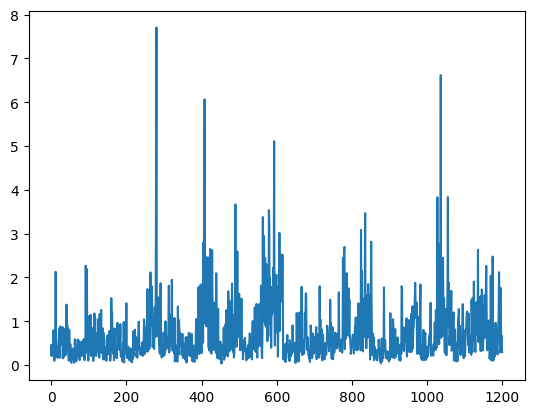

In [158]:


plt.plot(spndl_spectral_powers[1])


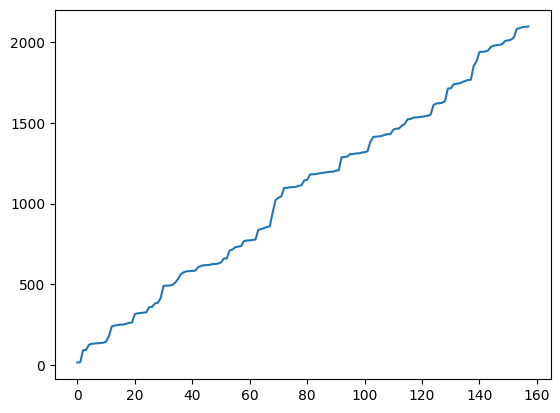

In [160]:
plt.plot(concatenated_spindle_times)


In [152]:
bin_centres[0]

0.5

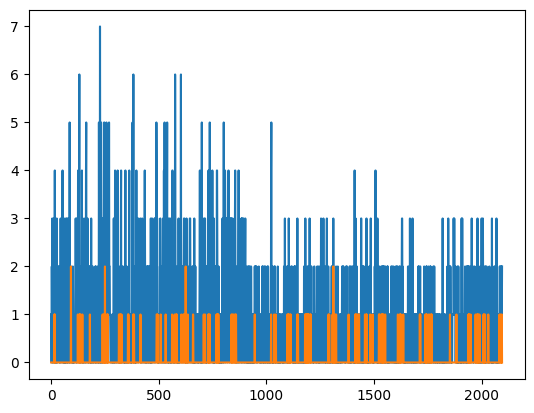

In [145]:
plt.plot(binned_replay)
plt.plot(binned_spindles)

In [ ]:
# logistic regression, causality 

# can features of spindles predict replay events?

# dependent variable = replay events, this needs to be a binary variable (0 or 1) for each time point in the data.
dependent_events = replay_fs_times
# independent variables = spindle features (peak amplitude,magnitude, duration, frequency, sleep stage, density?, time from sleep onset?)
# these need to be the same length as the dependent variable, so we need to bin them into the same time bins as the replay events.

independent_events_dict = {
    'peak_amplitude': chunk_spind_peaks,
    'magnitude': chunk_spind_total_magnitudes,
    'duration': chunk_spind_lengths,
    'average_magnitude': chunk_spind_av_magnitudes,
    'total magnitude': chunk_spind_total_magnitudes,
    'distance_to_replay': distance_to_replay
}

# time from sleep onset (first rem or nrem time...) if the spindle happens before sleep onset then just call it zero

# spindle density: number of spindles in a given time window (e.g. 10 window)

# sleep stage of each spindle event (nrem or rem) - this is already in the spindle events data frame, so just pull it out.

# cumulative spindle count over the last 2 minutes?

# spindle band power (zscored) ? 


# things to add... spindle phase locking with delta power?




In [ ]:
replay_fs_times

# i need to jsut concatenate the chunks, ignoring he gaps. 

In [36]:
replay_fs_times

array([3233.52253333, 3234.16143333, 3236.34183333, ..., 6119.68923333,
       6122.92573333, 6126.74913333])

In [ ]:
## logistic regression

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- 1. Prepare your data ---
# independent_events_dict = {...} # your spindle features dict
# replay_events = [...]           # your binary labels list (0 = no replay, 1 = replay)

X = pd.DataFrame(independent_events_dict)
y = np.array(replay_events)

# --- 2. Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Fit logistic regression ---
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# --- 4. Examine feature contributions ---
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Feature Importance:")
print(coef_df)


In [166]:
latency_to_spindle = [] 
for spin_event in chunk_spindles:
    upper = spin_event + 5
    lower = spin_event -5
    window_replay_events = replay_fs_times[(replay_fs_times < upper) * (replay_fs_times > lower)]
    if not len(window_replay_events) == 0:
        latency_to_spindle += list(window_replay_events - spin_event)

In [154]:
spin_event

6128.642000000001

In [153]:
window_replay_events

array([6124.34903333, 6127.20253333, 6123.76233333, 6124.85943333,
       6125.47733333, 6127.09213333, 6126.74913333])

In [136]:
for spin_time in spindle_mid_points:
    

SyntaxError: incomplete input (3582913634.py, line 2)

In [ ]:
### PSTH for spindles

# take each spindle and find the repla events around it... 


In [ ]:
## logistic regression
## can features of spindle activtiy predict replay? 



C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_22772\966258769.py:159: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_22772\966258769.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


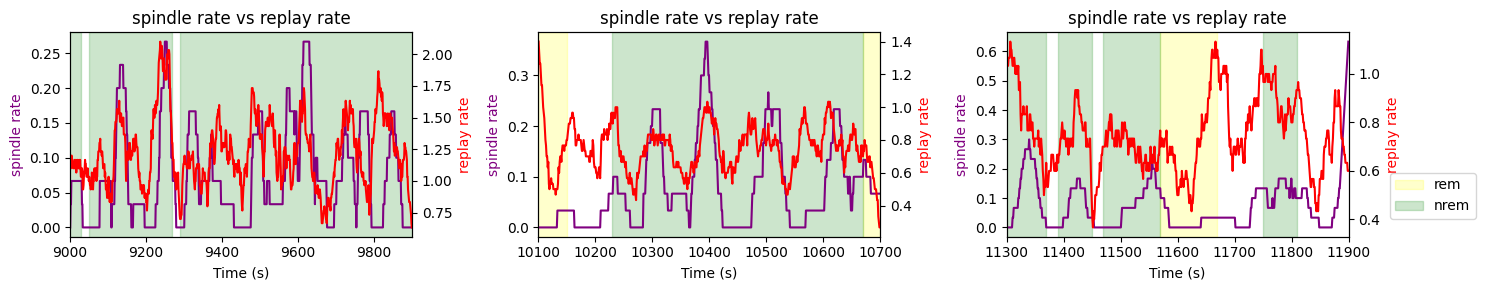

array([1.400000e-03, 1.926000e-01, 2.926100e+00, ..., 5.927977e+02,
       5.949709e+02, 5.951281e+02])

=== Testing A → B ===

=== Testing B → A ===


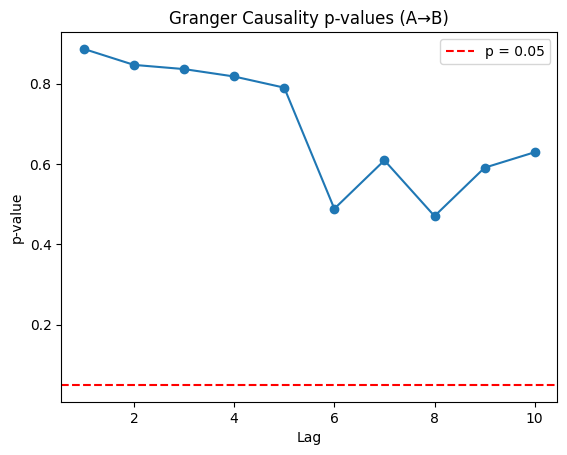

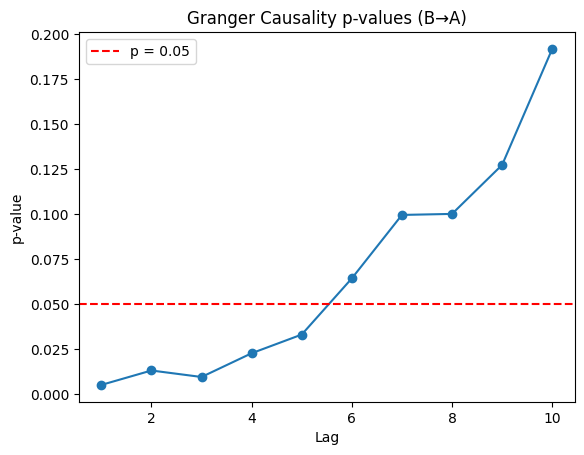

In [36]:
results = granger_causality_from_events(chunks_spindle_event_times[0],chunks_Replay_event_times[0],test_reverse = True)

plot_pvalues(results, direction="A→B")
plot_pvalues(results, direction="B→A")

In [33]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_from_events(events_A, events_B, bin_size=1.0, max_lag=10, test_reverse=False):
    """
    Test Granger causality between two event timestamp lists.
    
    Parameters:
    - events_A, events_B: lists or arrays of timestamps (floats or ints).
    - bin_size: size of time bins in same units as timestamps (e.g., seconds).
    - max_lag: maximum lag to test for Granger causality.
    - test_reverse: if True, also test B → A.
    
    Returns:
    - Dictionary of test results for A → B and (optionally) B → A.
    """

    # Combine all timestamps to find full time range
    all_times = np.concatenate([events_A, events_B])
    start_time = np.floor(all_times.min())
    end_time = np.ceil(all_times.max())
    
    # Create time bins
    bins = np.arange(start_time, end_time + bin_size, bin_size)

    # Bin the events
    A_counts, _ = np.histogram(events_A, bins)
    B_counts, _ = np.histogram(events_B, bins)

    # Prepare data for Granger causality: shape (n_samples, 2)
    # Granger wants [dependent, independent]
    data_AB = np.column_stack([B_counts, A_counts])
    data_BA = np.column_stack([A_counts, B_counts])

    results = {}

    print("=== Testing A → B ===")
    result_AB = grangercausalitytests(data_AB, maxlag=max_lag, verbose=False)
    results['A→B'] = {
        lag: {
            'F': result[0]['ssr_ftest'][0],
            'p-value': result[0]['ssr_ftest'][1]
        }
        for lag, result in result_AB.items()
    }

    if test_reverse:
        print("\n=== Testing B → A ===")
        result_BA = grangercausalitytests(data_BA, maxlag=max_lag, verbose=False)
        results['B→A'] = {
            lag: {
                'F': result[0]['ssr_ftest'][0],
                'p-value': result[0]['ssr_ftest'][1]
            }
            for lag, result in result_BA.items()
        }

    return results

def plot_pvalues(results, direction="A→B"):
    pvals = [stats['p-value'] for lag, stats in results[direction].items()]
    lags = list(results[direction].keys())
    plt.plot(lags, pvals, marker='o')
    plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
    plt.title(f'Granger Causality p-values ({direction})')
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.legend()
    plt.show()


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_404\550291032.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_404\550291032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


([[nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   na

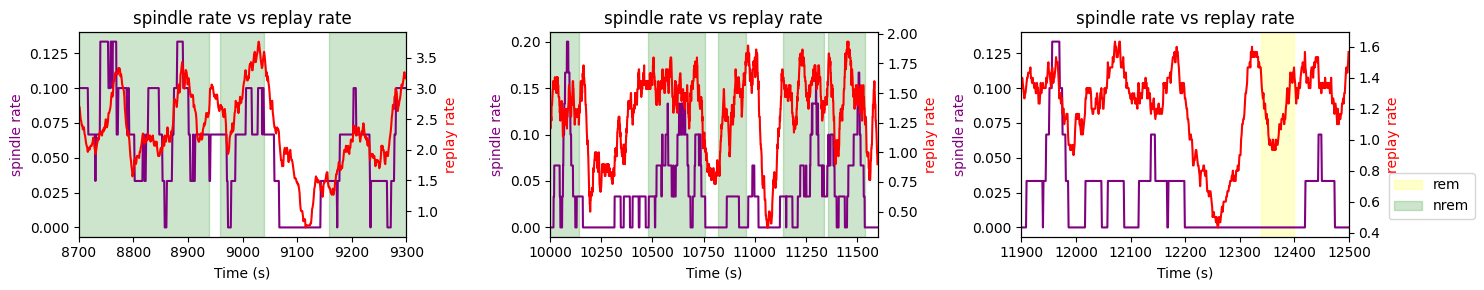

In [980]:
spin_event_times = [item['start_time'] for item in spindle_events]

fig,ax= plt.subplots(1, max(replay_events_df.chunk),figsize=(15, 3))
cumulative_chunk_time = 0
for i in range(max(replay_events_df.chunk)):
    chunk_dat = replay_events_df[replay_events_df.chunk == i+1]
    chunk_dat = chunk_dat.reset_index(drop = True)
    chunk_time = chunk_dat.chunk_time[0]  

    R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
    
    # bin into 1s bins and take replay rate 
    bin_size = 1
    hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
    
    # rebase the spindle times for the chunk timescale
    chunk_spin_event_times = np.array(spin_event_times)[(np.array(spin_event_times) > chunk_time[0])*(np.array(spin_event_times) < chunk_time[1])] - chunk_time[0]
    
    # bin into 1s bins and take spindle rate 
    bin_size = 1
    hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
    
    ## add to cumulative chunk time counter 
    cumulative_chunk_time += np.diff(chunk_time)[0]
    
    # Calculate bin centers
    bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]
    
    ax[i].plot(bin_centers,convolve_movmean(hist2,30), color = 'purple')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel(var_string,color = 'purple')
    ax[i].set_title(f'{var_string} vs replay rate')
    ax2 = ax[i].twinx()
    ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
    ax2.set_ylabel('replay rate', color = 'red')
    
    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_start_ends):
        label = 'rem' if ind == 0 else None
        ax[i].axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_start_ends):
        label = 'nrem' if ind == 0 else None
        ax[i].axvspan(start, end, color='green', alpha=0.2, label=label)
        
    ax[i].set_xlim(chunk_time[0], chunk_time[1])


    if i == max(replay_events_df.chunk) -1:
        # Move legend off to the right
        ax[i].legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
        
    # set the tight layout
    plt.tight_layout()
    


ValueError: x and y must have same first dimension, but have shapes (599,) and (39,)

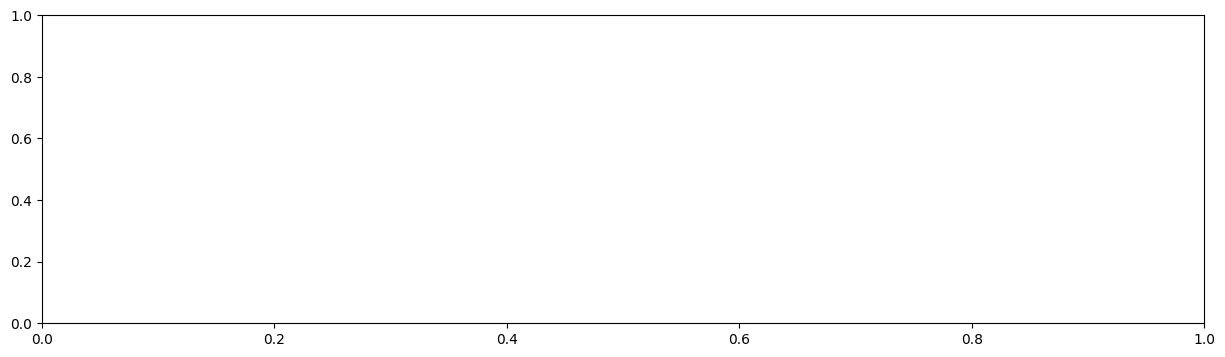

In [981]:
cross_corr_actual,temporal_shuffle,phase_shuff = calculate_cross_correlation(hist2, hist, smoothing_window,num_shuffles=1000)

# the significance of the cross correlation is determined by the 99th percentile of the shuffled data.
# there are two kinds of shuffle:
# 1. complete temporal shuffle. (random permutation) of the signal. The specral power is randoly shuffled in time. 
# 2. Phase randomization. scrambles the timing (phase) of each frequency component in a signal while keeping the frequency content (power spectrum) the same. This breaks any temporal alignment or structure (like shared rhythms) while preserving the overall shape and energy of the signal. 
### the second one is done by doing a fourier transforms (breaking it down into sine wave components) randomly shifting the phase of the components and then putting it backtogether
# i thought about and tried a circular shuffle but I think it doesnt make sense because there is undelrying periodicity.


# Plot the cross-correlation result
fig,ax= plt.subplots(1, 1,figsize=(15, 4))
time_lags = np.arange(-300 + 1, 300)
ax.plot(time_lags, np.mean(cross_corr_actual,axis = 0), label='Actual Cross-correlation')
ax.plot(time_lags, np.mean(temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
ax.plot(time_lags, np.mean(phase_shuff,axis = 0), label='99 %ile phase shuffle')
ax.axvline(0,color = 'grey')
ax.set_xlabel('Time Lag')
ax.set_ylabel('Cross-correlation')
ax.set_title(f'correlation between Delta spectral power and replay events')
ax.legend()

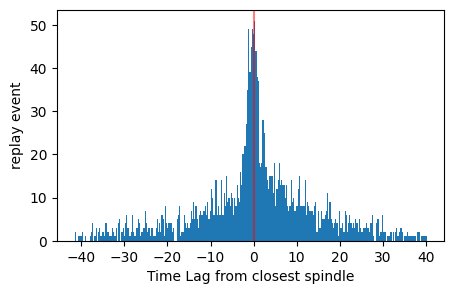

In [932]:
convolve_movmean(replay_fs_times,30)

array([ 604.6034488 ,  605.1055688 ,  605.71099213, ..., 4370.0096688 ,
       4373.27131213, 4376.40906546])

In [931]:
replay_fs_times

array([ 600.8107588,  601.0019588,  603.7354588, ..., 4389.0473588,
       4392.2041588, 4396.8724588])

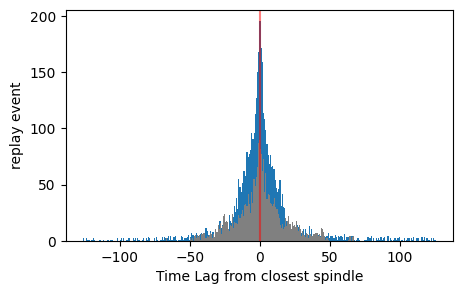

In [920]:
replay_mid_times + 5

array([ 605.8386088,  606.0511088,  608.7612588, ..., 4394.5006588,
       4398.2061588, 4402.9414588])

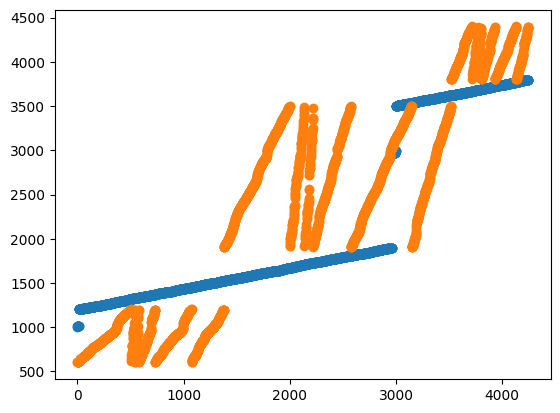

In [ ]:
for i in range(replay_mid_times):
    x = round(random.uniform(0, 1000), 3)



In [ ]:
# was there a spindle assosiated with replay? 

In [881]:
x

102.021

In [924]:
random_replay_events = generate_random_numbers(len(replay_mid_times), min(replay_mid_times), max(replay_mid_times), replay_mid_times)


(array([ 5.69903745e-05,  5.82339226e-05,  5.93505796e-05, ...,
        -1.15953507e-04, -1.21337171e-04, -1.26578110e-04]),
 array([0.00807308, 0.0080727 , 0.00807232, ..., 0.00807763, 0.00807764,
        0.00807767]),
 array([9.49323477e-05, 9.39808557e-05, 9.29710980e-05, ...,
        1.66080086e-04, 1.72888155e-04, 1.79520179e-04]))

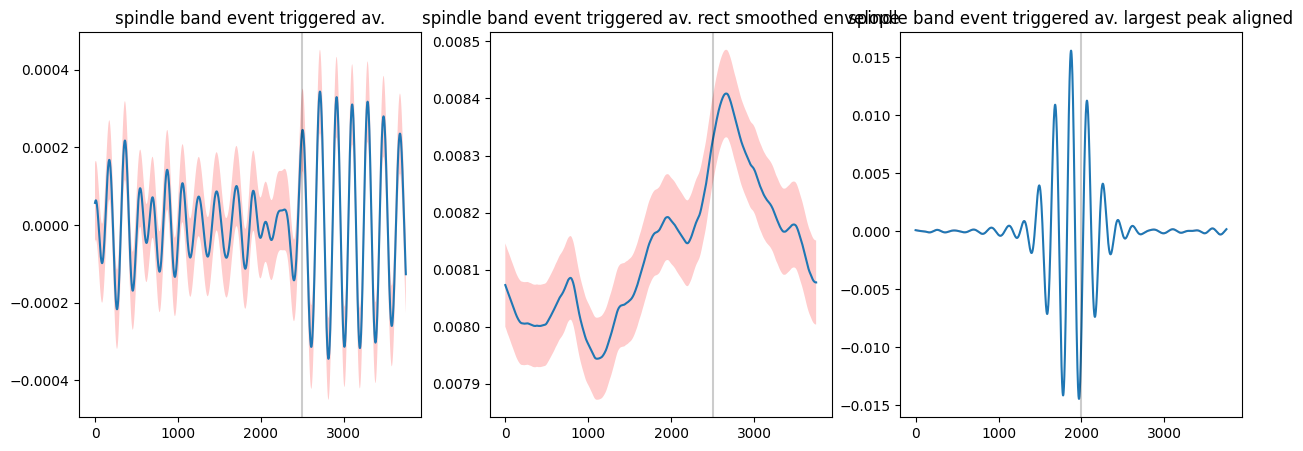

(array([-8.67119513e-06, -1.05031259e-05, -1.23072042e-05, ...,
        -1.93311683e-05, -1.54643526e-05, -1.15581901e-05]),
 array([0.00805621, 0.00805613, 0.00805605, ..., 0.0080753 , 0.00807563,
        0.00807596]),
 array([0.00013767, 0.00013415, 0.00013053, ..., 0.00011334, 0.00011829,
        0.00012311]))

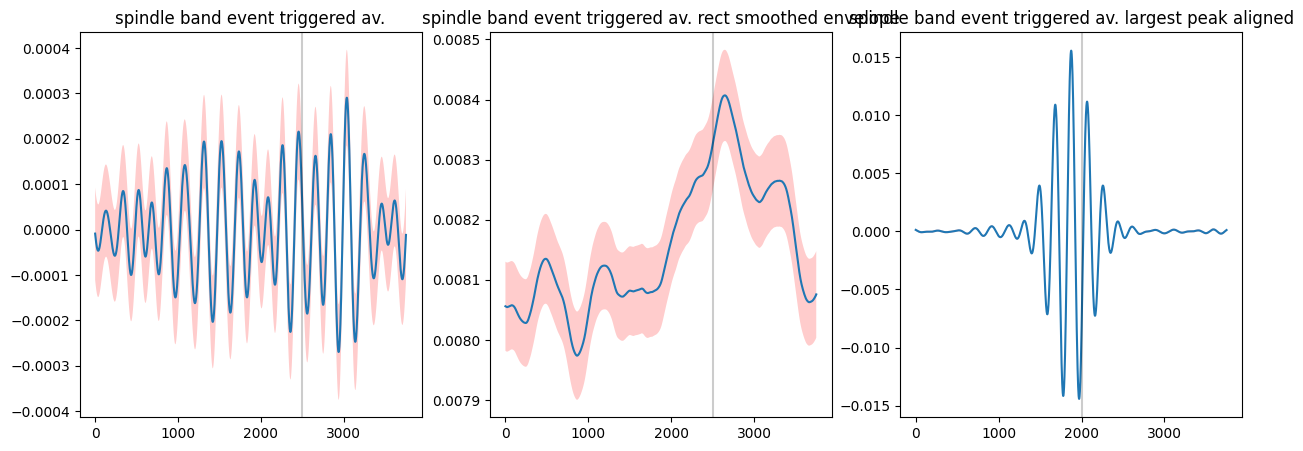

In [823]:
plot_spindle_etas(replay_mid_times,spindle_bandpassed,smoothed_envelope)

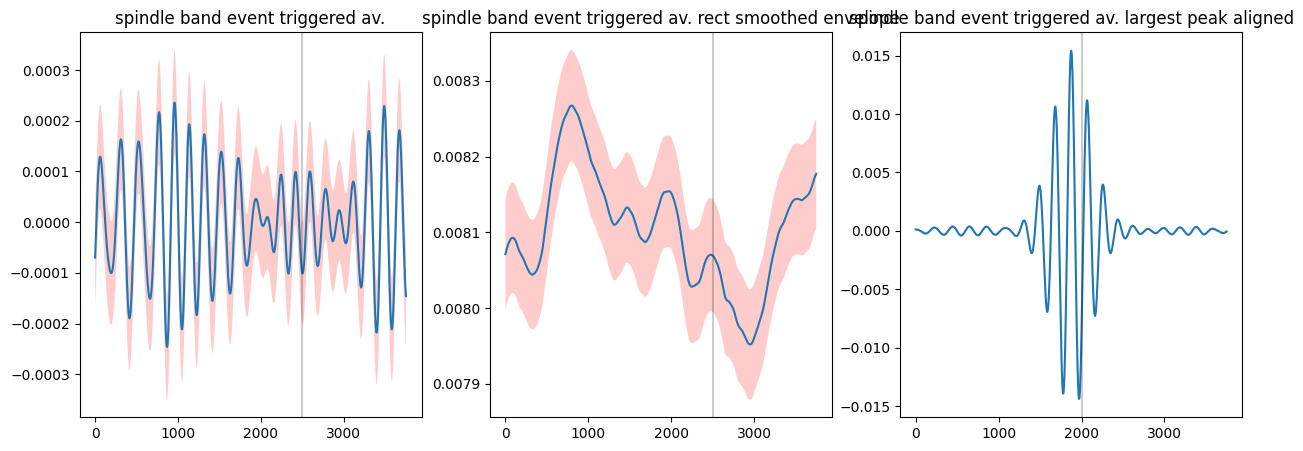

In [829]:
### spindle NOISE
import random

# Define a function to generate random numbers within a range and exclude values
def generate_random_numbers(n, start, end, exclude_list):
    result = []
    while len(result) < n:
        x = round(random.uniform(start, end), 3)
        if all(abs(x - r) >= 3 for r in exclude_list):
            result.append(x)
    return result

# generate random event times excluding replay event times 
random_replay_events = generate_random_numbers(len(replay_mid_times), min(replay_mid_times), max(replay_mid_times), replay_mid_times)

average_signal,average_signal_rect,peak_algined_average_signal = plot_spindle_etas(random_replay_events,spindle_bandpassed,smoothed_envelope)

# out_df = pd.DataFrame({'eta':average_signal ,'eta_rect':average_signal_rect,'peak_aligned_eta':peak_algined_average_signal})
# out_df.to_csv(replay_data_path + 'LFP_analysis\\random_spindle_eta_df')


600.838608796802

In [816]:
windows, time_vector, valid_events = extract_windows_rounded(spindle_bandpassed, replay_fs_times, fs, window_duration=3.0)

In [800]:
for replay_time in replay_fs_times:
    replay_time

spindle_bandpassed
    

array([0.1884597 , 0.16913074, 0.15007819, ..., 0.00532945, 0.00532945,
       0.00532945])

In [818]:
windows, time_vector, valid_events = extract_interpolated_windows(spindle_bandpassed, replay_fs_times, fs, window_duration=3.0)

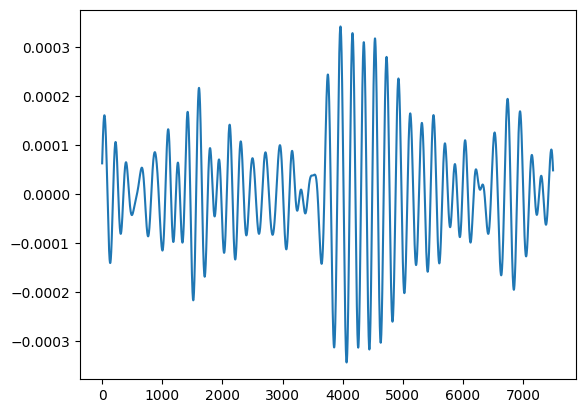

In [819]:

plt.plot(np.mean(windows,axis =0))

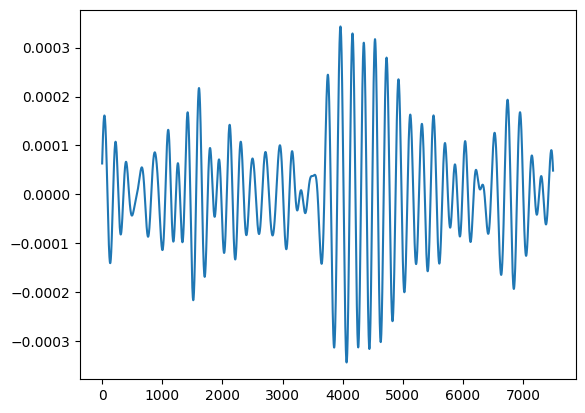

In [817]:

plt.plot(np.mean(windows,axis =0))

In [815]:
import numpy as np

def extract_windows_rounded(signal, event_times, fs, window_duration=3.0):
    """
    Extract fixed-length windows around event times using sample rounding (no interpolation).

    Parameters:
        signal (np.ndarray): 1D array of the signal.
        event_times (list or array): Event times in seconds.
        fs (int): Sampling frequency in Hz.
        window_duration (float): Total window length in seconds (default 3.0).

    Returns:
        windows (list of np.ndarray): List of extracted windows.
        time_vector (np.ndarray): Relative time axis for each window (centered on 0).
        valid_events (list): Event times that were successfully used.
    """
    signal = np.asarray(signal)
    num_samples = int(window_duration * fs)
    half_samples = num_samples // 2
    half_window = window_duration / 2

    time_vector = np.linspace(-half_window, half_window, num_samples, endpoint=False)
    windows = []
    valid_events = []

    for t in event_times:
        center_idx = round(t * fs)
        start_idx = center_idx - half_samples
        end_idx = center_idx + half_samples

        if start_idx < 0 or end_idx > len(signal):
            print(f"Skipping event at {t:.4f}s (window would be out of bounds)")
            continue

        window = signal[start_idx:end_idx]
        windows.append(window)
        valid_events.append(t)

    return windows, time_vector, valid_events



In [805]:
import numpy as np
from scipy.interpolate import interp1d

def extract_interpolated_windows(signal, event_times, fs, window_duration=3.0):
    """
    Extracts windows around event times using linear interpolation
    to precisely center windows at fractional event times.
    
    Returns interpolated windows and their associated time vectors.
    """
    signal = np.asarray(signal)
    time_axis = np.arange(len(signal)) / fs
    interp_func = interp1d(time_axis, signal, kind='linear', bounds_error=False, fill_value=np.nan)

    half_window = window_duration / 2
    num_samples = int(window_duration * fs)
    time_vector = np.linspace(-half_window, half_window, num_samples, endpoint=False)

    windows = []
    valid_events = []

    for t in event_times:
        window_times = t + time_vector
        if window_times[0] < time_axis[0] or window_times[-1] > time_axis[-1]:
            print(f"Skipping event at {t:.4f}s (window would be out of bounds)")
            continue
        window = interp_func(window_times)
        windows.append(window)
        valid_events.append(t)

    return windows, time_vector, valid_events


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

def granger_causality_bidirectional(series_A, series_B, max_lag=10, plot=True):
    """
    Perform Granger causality tests in both directions between two time series.
    
    Parameters:
    - series_A: array-like, first time series
    - series_B: array-like, second time series
    - max_lag: maximum lag to test
    - plot: if True, plot p-values for both directions
    
    Returns:
    - Dictionary with results for 'A→B' and 'B→A'
    """
    assert len(series_A) == len(series_B), "Series must have the same length"
    
    # DataFrames for each direction
    data_AB = pd.DataFrame({'B': series_B, 'A': series_A})
    data_BA = pd.DataFrame({'A': series_A, 'B': series_B})
    
    # Granger tests
    print("Testing A → B")
    results_AB = grangercausalitytests(data_AB[['B', 'A']], maxlag=max_lag, verbose=False)
    
    print("\nTesting B → A")
    results_BA = grangercausalitytests(data_BA[['A', 'B']], maxlag=max_lag, verbose=False)
    
    stats_AB = {
        lag: {
            'F': r[0]['ssr_ftest'][0],
            'p-value': r[0]['ssr_ftest'][1]
        } for lag, r in results_AB.items()
    }

    stats_BA = {
        lag: {
            'F': r[0]['ssr_ftest'][0],
            'p-value': r[0]['ssr_ftest'][1]
        } for lag, r in results_BA.items()
    }

    if plot:
        lags = list(stats_AB.keys())
        pvals_AB = [stats_AB[lag]['p-value'] for lag in lags]
        pvals_BA = [stats_BA[lag]['p-value'] for lag in lags]

        plt.plot(lags, pvals_AB, marker='o', label='A → B')
        plt.plot(lags, pvals_BA, marker='s', label='B → A')
        plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
        plt.title('Granger Causality p-values (Both Directions)')
        plt.xlabel('Lag')
        plt.ylabel('p-value')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {'A→B': stats_AB, 'B→A': stats_BA}


results = granger_causality_bidirectional(replay_aligned_spndl_spectral_powers[0],spndl_replay_binned[0])

In [803]:
len(spindle_bandpassed)

12970801

In [802]:
replay_time * 2500 

10992181.146992004

In [ ]:
## average spindle during replay 

# find replay times and define a window of +/- 1.5s around the replay event

# chop out these times from the spindle band and average them.

# do peak alinged averaging and rectified magnitude averaging 

# compare this to random non replay times. 





In [ ]:


## spindles linked to replay histogram 

## percentage of replay events with a spindle associated

